# 学習済みのCNNを使用する

ドライブをマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


VGG16モデルの畳み込みベースのインスタンス化

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 7s 0us/step


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

学習済み畳み込みベースを使って特徴量を抽出

In [0]:
import os

os.chdir('drive/My Drive/機械学習')

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# 前ノートでsmallデータを格納したディレクトリへのパスであることに注意
base_dir = 'cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
        # ジェネレータはデータを無限に生成するため、画像をひととおり処理したらbreakしなければならない
            break
      
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


抽出された特徴量の現時点の形状は(sample, 4, 4, 512)
全結合分類器に供給する為に(sample, 8192)に平坦化

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

全結合分類器の定義と訓練

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 657us/step - loss: 0.5901 - acc: 0.6750 - val_loss: 0.4490 - val_acc: 0.8430
Epoch 2/30
2000/2000 [==============================] - 1s 428us/step - loss: 0.4375 - acc: 0.8035 - val_loss: 0.3670 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 1s 439us/step - loss: 0.3535 - acc: 0.8545 - val_loss: 0.3259 - val_acc: 0.8700
Epoch 4/30
2000/2000 [==============================] - 1s 436us/step - loss: 0.3264 - acc: 0.8610 - val_loss: 0.3170 - val_acc: 0.8670
Epoch 5/30
2000/2000 [==============================] - 1s 433us/step - loss: 0.2933 - acc: 0.8820 - val_loss: 0.2887 - val_acc: 0.8860
Epoch 6/30
2000/2000 [==============================] - 1s 442us/step - loss: 0.2676 - acc: 0.8935 - val_loss: 0.2745 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 1s 439us/step - loss: 0.2492 - acc: 0.9035 - val_loss: 0.2652 - val_acc: 0.8930


結果をプロット

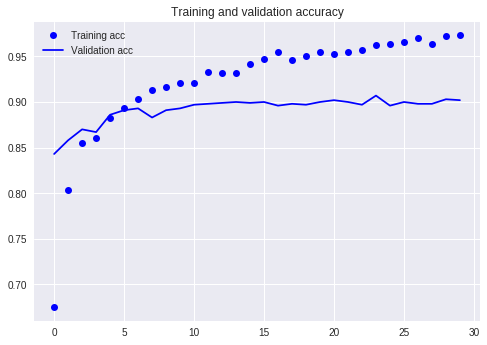

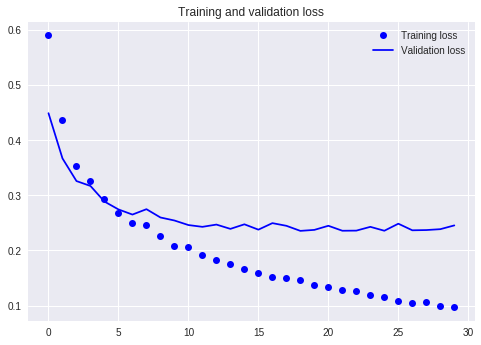

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# 正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# 損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# データ拡張を行う特徴抽出

畳み込みベースに全結合分類器を追加

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


分類器だけを学習させたいので畳み込みベース（VGG16）を凍結させる

In [12]:
print('This is the number of trainable weights ''before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [13]:
conv_base.trainable = False
print('This is the number of trainable weights ''after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


凍結された畳み込みベースを使ってモデル全体を訓練

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

# 検証データは水増しすべきではないことに注意
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=50,
                             verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 32s - loss: 0.6066 - acc: 0.6730 - val_loss: 0.4720 - val_acc: 0.8090
Epoch 2/30
 - 29s - loss: 0.4964 - acc: 0.7760 - val_loss: 0.3897 - val_acc: 0.8260
Epoch 3/30
 - 29s - loss: 0.4405 - acc: 0.8045 - val_loss: 0.3419 - val_acc: 0.8680
Epoch 4/30
 - 29s - loss: 0.4143 - acc: 0.8180 - val_loss: 0.3240 - val_acc: 0.8680
Epoch 5/30
 - 29s - loss: 0.3867 - acc: 0.8295 - val_loss: 0.3011 - val_acc: 0.8740
Epoch 6/30
 - 29s - loss: 0.3729 - acc: 0.8340 - val_loss: 0.2923 - val_acc: 0.8760
Epoch 7/30
 - 30s - loss: 0.3622 - acc: 0.8435 - val_loss: 0.2827 - val_acc: 0.8830
Epoch 8/30
 - 29s - loss: 0.3470 - acc: 0.8490 - val_loss: 0.2760 - val_acc: 0.8880
Epoch 9/30
 - 29s - loss: 0.3379 - acc: 0.8470 - val_loss: 0.2655 - val_acc: 0.8880
Epoch 10/30
 - 29s - loss: 0.3382 - acc: 0.8525 - val_loss: 0.2789 - val_acc: 0.8780
Epoch 11/30
 - 29s - loss: 0.3304 - acc: 0.8570 - val_loss: 0.2585 - val_ac

結果をプロット

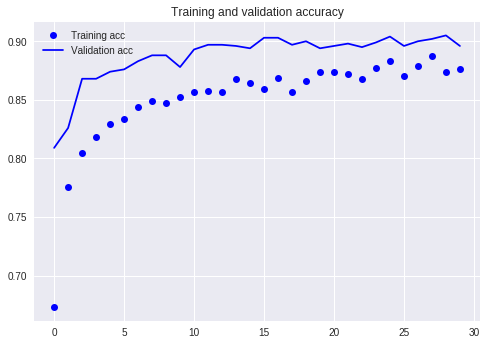

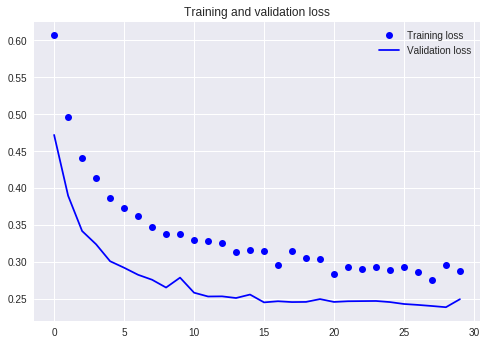

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# ファインチューニング

In [16]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

最初から特定の層までを全て凍結

In [0]:
conv_base.trainable = True

set_trainable = False
for layers in conv_base.layers:
    if layers.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layers.trainable = True
    else:
        layers.trainable = False

モデルのファインチューニング

In [19]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=100,
                             validation_data=validation_generator,
                             validation_steps=50)

Epoch 1/100
100/100 [==============================] - 33s 332ms/step - loss: 0.2913 - acc: 0.8790 - val_loss: 0.2242 - val_acc: 0.9110
Epoch 2/100
100/100 [==============================] - 31s 314ms/step - loss: 0.2582 - acc: 0.8900 - val_loss: 0.2253 - val_acc: 0.9190
Epoch 3/100
100/100 [==============================] - 31s 310ms/step - loss: 0.2316 - acc: 0.9010 - val_loss: 0.2116 - val_acc: 0.9180
Epoch 4/100
100/100 [==============================] - 31s 310ms/step - loss: 0.2189 - acc: 0.9065 - val_loss: 0.1954 - val_acc: 0.9180
Epoch 5/100
100/100 [==============================] - 31s 312ms/step - loss: 0.2221 - acc: 0.9065 - val_loss: 0.1960 - val_acc: 0.9200
Epoch 6/100
100/100 [==============================] - 31s 313ms/step - loss: 0.1924 - acc: 0.9205 - val_loss: 0.2047 - val_acc: 0.9210
Epoch 7/100
100/100 [==============================] - 31s 310ms/step - loss: 0.1859 - acc: 0.9220 - val_loss: 0.1919 - val_acc: 0.9270
Epoch 8/100
100/100 [===========================

結果をプロット

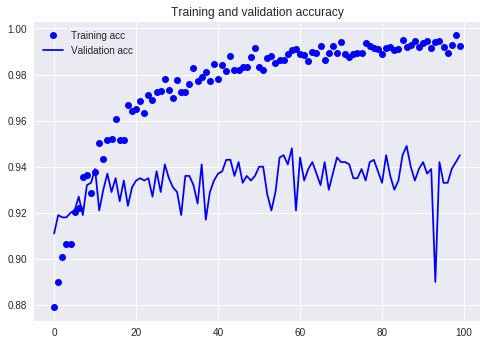

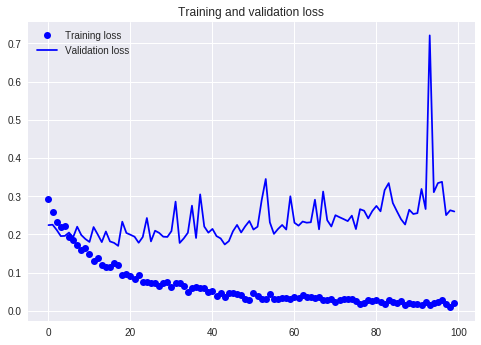

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

プロットのスムージング

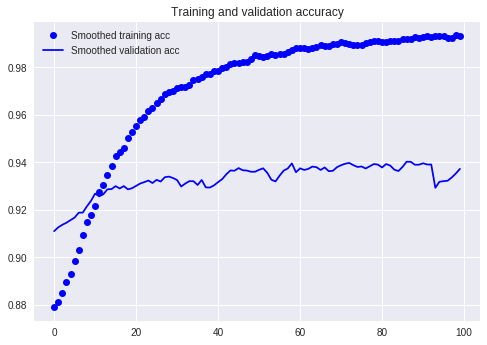

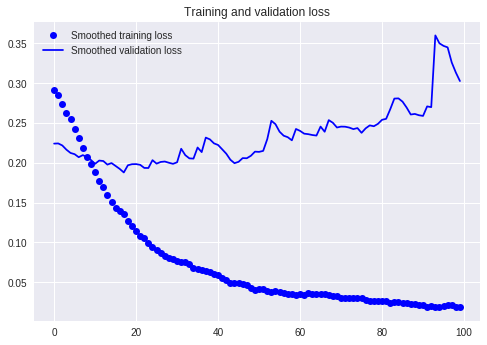

In [28]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

テストデータでの評価

In [29]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9369999921321869
